# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [10]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [11]:
X.shape

(1797, 64)

In [13]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=360)

Epoch 1/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7710 - accuracy: 0.6611
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5990 - accuracy: 0.7418
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5118 - accuracy: 0.7791
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4561 - accuracy: 0.8069
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4146 - accuracy: 0.8286
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3835 - accuracy: 0.8442
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.3572 - accuracy: 0.8548
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3392 - accuracy: 0.8653
Epoch 9/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3194 - accuracy: 0.8759
Epoch 10/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3076 - accuracy: 0.8820
Epoch 11/50
5/5 [================

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                780       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [14]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [15]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 13ms/step - loss: 0.7191 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.7134 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7088 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7053 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 8ms/step - loss: 0.7021 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 8ms/step - loss: 0.6997 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.6978 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 8ms/step - loss: 0.6963 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.6951 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6943 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [16]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x293c795d0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7191162109375,
   0.7134284377098083,
   0.7087740302085876,
   0.7052584886550903,
   0.702105700969696,
   0.6996777057647705,
   0.6977685689926147,
   0.6962804198265076,
   0.6950886845588684,
   0.6943196058273315],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [18]:
results.history

{'loss': [0.7191162109375,
  0.7134284377098083,
  0.7087740302085876,
  0.7052584886550903,
  0.702105700969696,
  0.6996777057647705,
  0.6977685689926147,
  0.6962804198265076,
  0.6950886845588684,
  0.6943196058273315],
 'accuracy': [0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434]}

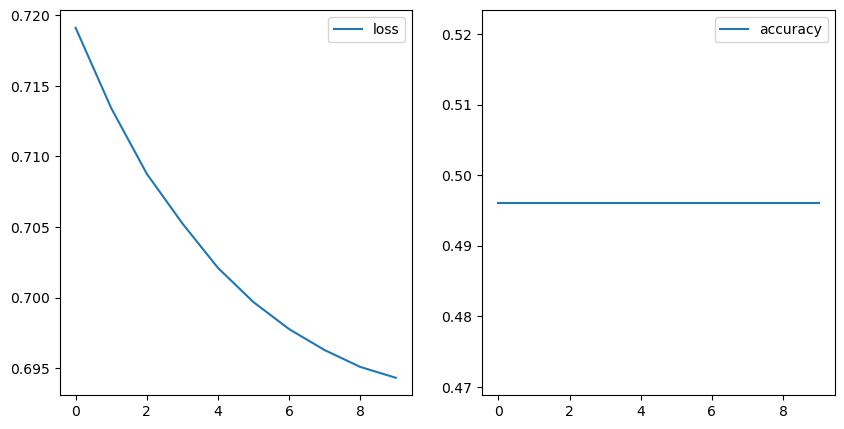

In [19]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [22]:
X_pure_train.shape[0]

1149

In [23]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 8ms/step - loss: 0.6657 - accuracy: 0.5692
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6493 - accuracy: 0.6658
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6324 - accuracy: 0.7459
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.6140 - accuracy: 0.7598
Epoch 5/100
36/36 [==============================] - 0s 10ms/step - loss: 0.5937 - accuracy: 0.7807
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5725 - accuracy: 0.7946
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 0.5505 - accuracy: 0.8111
Epoch 8/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5274 - accuracy: 0.8155
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5035 - accuracy: 0.8207
Epoch 10/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4797 - accuracy: 0.8277
Epoch 1

Epoch 83/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1436 - accuracy: 0.9373
Epoch 84/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1406 - accuracy: 0.9408
Epoch 85/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.9373
Epoch 86/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1378 - accuracy: 0.9408
Epoch 87/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1379 - accuracy: 0.9399
Epoch 88/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1363 - accuracy: 0.9434
Epoch 89/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.9391
Epoch 90/100
36/36 [==============================] - 0s 8ms/step - loss: 0.1350 - accuracy: 0.9399
Epoch 91/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1330 - accuracy: 0.9426
Epoch 92/100
36/36 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.9452


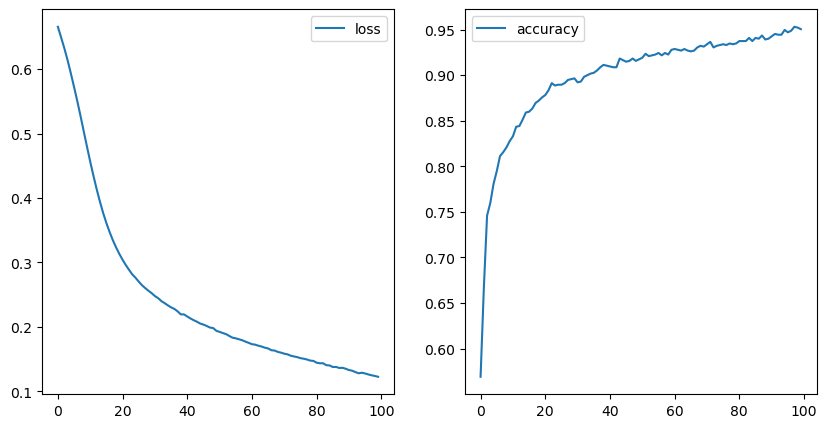

In [24]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

In [26]:
from tensorflow.keras.optimizers.legacy import SGD

Epoch 1/30
115/115 [==============================] - 1s 7ms/step - loss: 1.3750 - accuracy: 0.5013
Epoch 2/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9302 - accuracy: 0.5074
Epoch 3/30
115/115 [==============================] - 1s 8ms/step - loss: 0.9580 - accuracy: 0.5065
Epoch 4/30
115/115 [==============================] - 1s 8ms/step - loss: 0.9331 - accuracy: 0.5178
Epoch 5/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0981 - accuracy: 0.4987
Epoch 6/30
115/115 [==============================] - 1s 8ms/step - loss: 1.0557 - accuracy: 0.4735
Epoch 7/30
115/115 [==============================] - 1s 8ms/step - loss: 0.9131 - accuracy: 0.5187
Epoch 8/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0382 - accuracy: 0.4874
Epoch 9/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0238 - accuracy: 0.4769
Epoch 10/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0076 - accuracy: 0.5065

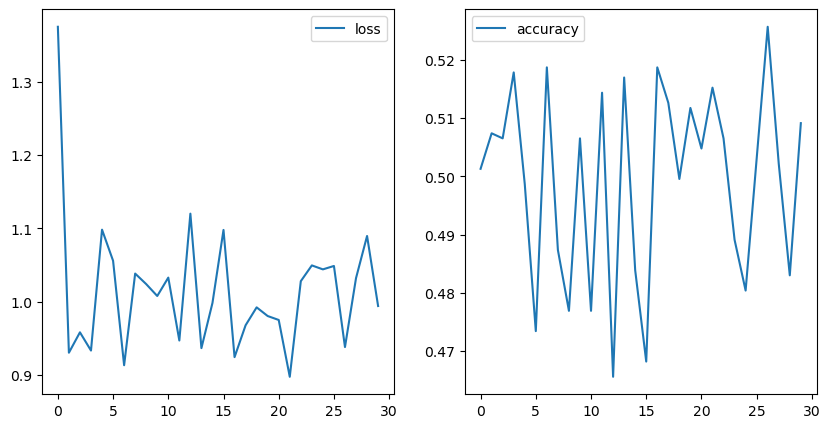

In [29]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 2s 15ms/step - loss: 0.6285 - accuracy: 0.6379 - val_loss: 0.5816 - val_accuracy: 0.7257
Epoch 2/30
115/115 [==============================] - 2s 15ms/step - loss: 0.4910 - accuracy: 0.8320 - val_loss: 0.4162 - val_accuracy: 0.8646
Epoch 3/30
115/115 [==============================] - 2s 14ms/step - loss: 0.3527 - accuracy: 0.8755 - val_loss: 0.2992 - val_accuracy: 0.8889
Epoch 4/30
115/115 [==============================] - 2s 13ms/step - loss: 0.2708 - accuracy: 0.9051 - val_loss: 0.2467 - val_accuracy: 0.9201
Epoch 5/30
115/115 [==============================] - 2s 14ms/step - loss: 0.2240 - accuracy: 0.9147 - val_loss: 0.2254 - val_accuracy: 0.9028
Epoch 6/30
115/115 [==============================] - 2s 13ms/step - loss: 0.1960 - accuracy: 0.9182 - val_loss: 0.2073 - val_accuracy: 0.9097
Epoch 7/30
115/115 [==============================] - 2s 14ms/step - loss: 0.1784 - accuracy: 0.9278 - val_loss: 0.1938 - val_accuracy: 0.9167

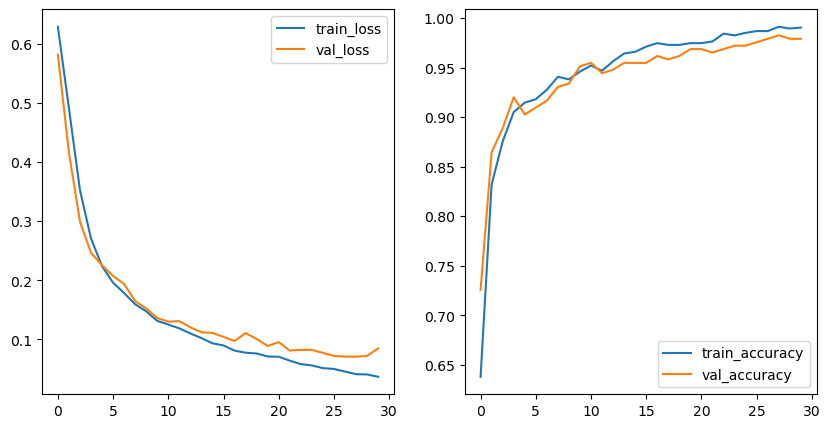

In [30]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train,
                    validation_data=(X_val, y_val),
                   epochs=30, batch_size=10, verbose=1)

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [31]:
# Model validation accuracy at the end
results.history['val_accuracy'][-1]

0.9791666865348816

In [32]:
model.evaluate(X_val, y_val)

9/9 [==============================] - 0s 5ms/step - loss: 0.0850 - accuracy: 0.9792


[0.0850047767162323, 0.9791666865348816]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [33]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x29dc96320> does not.

In [34]:
# Need to define a function to build the model
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [35]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=1)

/var/folders/0c/wkrr_xjn2xz65fx41rj45h6w0000gp/T/ipykernel_10391/2453450268.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [36]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [ ]:
keras_model

In [37]:
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
24/24 [==============================] - 1s 16ms/step - loss: 0.6785 - accuracy: 0.5405
Epoch 2/50
24/24 [==============================] - 0s 12ms/step - loss: 0.6243 - accuracy: 0.7533
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 0.5409 - accuracy: 0.8381
Epoch 4/50
24/24 [==============================] - 0s 12ms/step - loss: 0.4604 - accuracy: 0.8655
Epoch 5/50
24/24 [==============================] - 0s 12ms/step - loss: 0.3949 - accuracy: 0.8734
Epoch 6/50
24/24 [==============================] - 0s 11ms/step - loss: 0.3443 - accuracy: 0.8877
Epoch 7/50
24/24 [==============================] - 0s 11ms/step - loss: 0.3075 - accuracy: 0.8916
Epoch 8/50
24/24 [==============================] - 0s 12ms/step - loss: 0.2783 - accuracy: 0.9021
Epoch 9/50
24/24 [==============================] - 0s 12ms/step - loss: 0.2575 - accuracy: 0.9060
Epoch 10/50
24/24 [==============================] - 0s 14ms/step - loss: 0.2417 - accuracy: 0.9125
Epoch 11/

24/24 [==============================] - 0s 13ms/step - loss: 0.0960 - accuracy: 0.9687
Epoch 33/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0905 - accuracy: 0.9713
Epoch 34/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0878 - accuracy: 0.9804
Epoch 35/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0829 - accuracy: 0.9830
Epoch 36/50
24/24 [==============================] - 0s 14ms/step - loss: 0.0825 - accuracy: 0.9778
Epoch 37/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0793 - accuracy: 0.9778
Epoch 38/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0762 - accuracy: 0.9791
Epoch 39/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0726 - accuracy: 0.9791
Epoch 40/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0709 - accuracy: 0.9869
Epoch 41/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0668 - accuracy: 0.9869
Epoch 42/50


array([0.94255877, 0.9634465 , 0.95822453])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

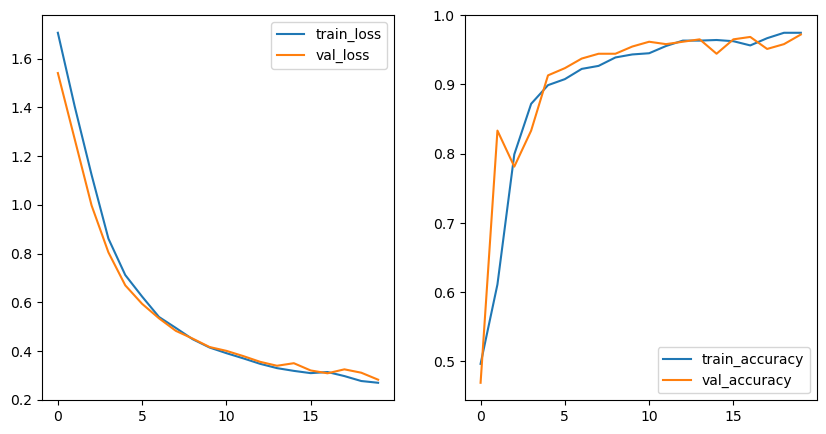

In [38]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

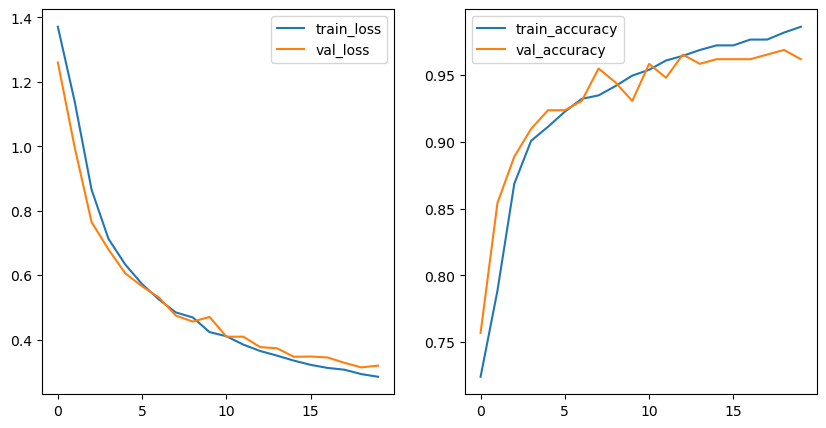

In [39]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

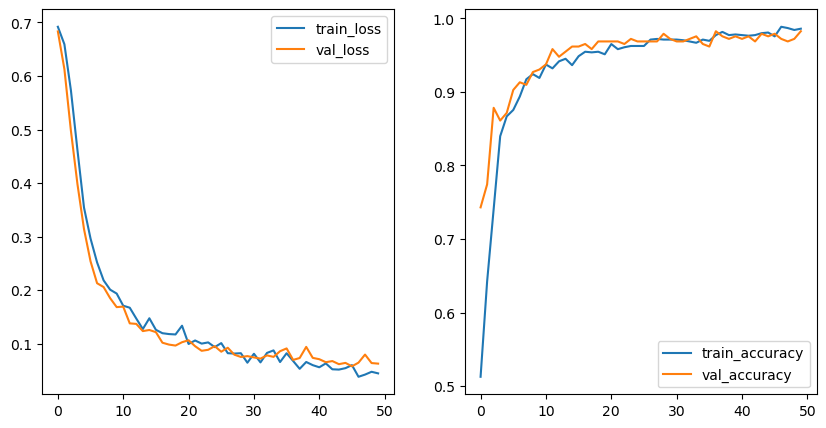

In [40]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dropout(.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [41]:
results.history['val_accuracy'][-1]

0.9826388955116272

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 8: early stopping


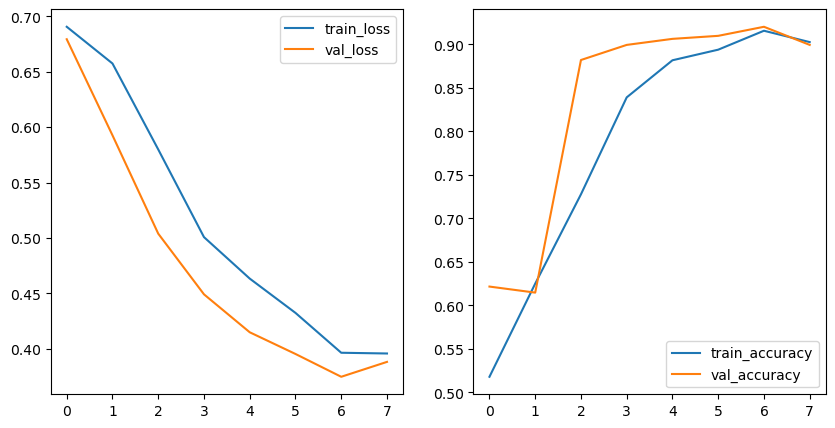

In [42]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                          verbose=1, mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 1/100
36/36 [==============================] - 3s 45ms/step - loss: 0.6756 - accuracy: 0.5596 - val_loss: 0.6408 - val_accuracy: 0.6562
Epoch 2/100
36/36 [==============================] - 1s 24ms/step - loss: 0.5909 - accuracy: 0.7232 - val_loss: 0.5247 - val_accuracy: 0.8715
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.4999 - accuracy: 0.8312 - val_loss: 0.4135 - val_accuracy: 0.8854
Epoch 4/100
36/36 [==============================] - 1s 28ms/step - loss: 0.4020 - accuracy: 0.8903 - val_loss: 0.3394 - val_accuracy: 0.8993
Epoch 5/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3158 - accuracy: 0.9051 - val_loss: 0.2511 - val_accuracy: 0.9236
Epoch 6/100
36/36 [==============================] - 1s 25ms/step - loss: 0.2550 - accuracy: 0.9138 - val_loss: 0.1960 - val_accuracy: 0.9236
Epoch 7/100
36/36 [==============================] - 1s 26ms/step - loss: 0.2067 - accuracy: 0.9260 - val_loss: 0.1813 - val_accuracy: 0.9340
Epoch 

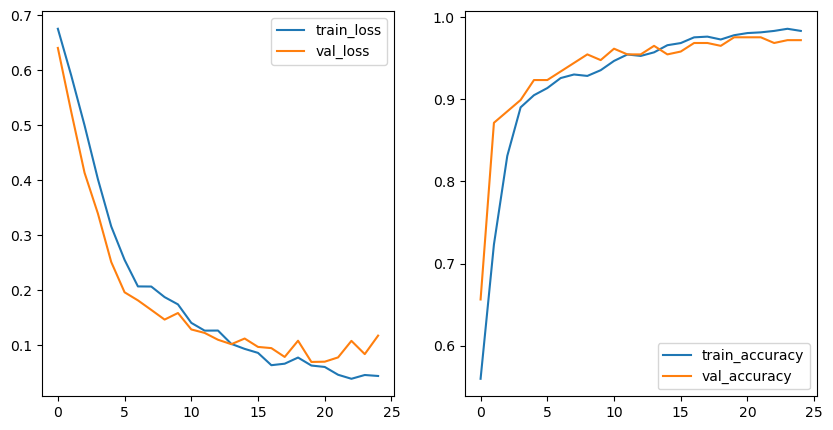

In [43]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=100, batch_size= 32,
                    verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [44]:
results.history['val_accuracy'][-1]

0.9722222089767456

In [47]:
len(results.history['loss'])

25

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [51]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

In [53]:
y

array([0., 1., 2., ..., 8., 9., 8.], dtype=float32)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [54]:
y_pure_train.reshape(-1,1)

array([[8.],
       [7.],
       [4.],
       ...,
       [1.],
       [2.],
       [8.]], dtype=float32)

For a multiclass output, our neural net expects our target to be in a certain form.

In [55]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [57]:
y_test.shape

(360, 10)

In [66]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50


ValueError: in user code:

    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/danielburdeno/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 5) are incompatible


In [67]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 3s 18ms/step - loss: 2.2702 - accuracy: 0.1097 - val_loss: 2.1637 - val_accuracy: 0.2049
Epoch 2/50
115/115 [==============================] - 2s 16ms/step - loss: 2.0541 - accuracy: 0.3299 - val_loss: 1.8264 - val_accuracy: 0.4618
Epoch 3/50
115/115 [==============================] - 2s 18ms/step - loss: 1.6425 - accuracy: 0.5065 - val_loss: 1.4155 - val_accuracy: 0.6076
Epoch 4/50
115/115 [==============================] - 2s 19ms/step - loss: 1.2339 - accuracy: 0.6789 - val_loss: 1.0613 - val_accuracy: 0.7049
Epoch 5/50
115/115 [==============================] - 2s 17ms/step - loss: 0.9256 - accuracy: 0.7528 - val_loss: 0.8391 - val_accuracy: 0.7778
Epoch 6/50
115/115 [==============================] - 2s 16ms/step - loss: 0.7393 - accuracy: 0.8085 - val_loss: 0.7034 - val_accuracy: 0.7986
Epoch 7/50
115/115 [==============================] - 2s 16ms/step - loss: 0.6202 - accuracy: 0.8338 - val_loss: 0.6184 - val_accuracy: 0.8264

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [59]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

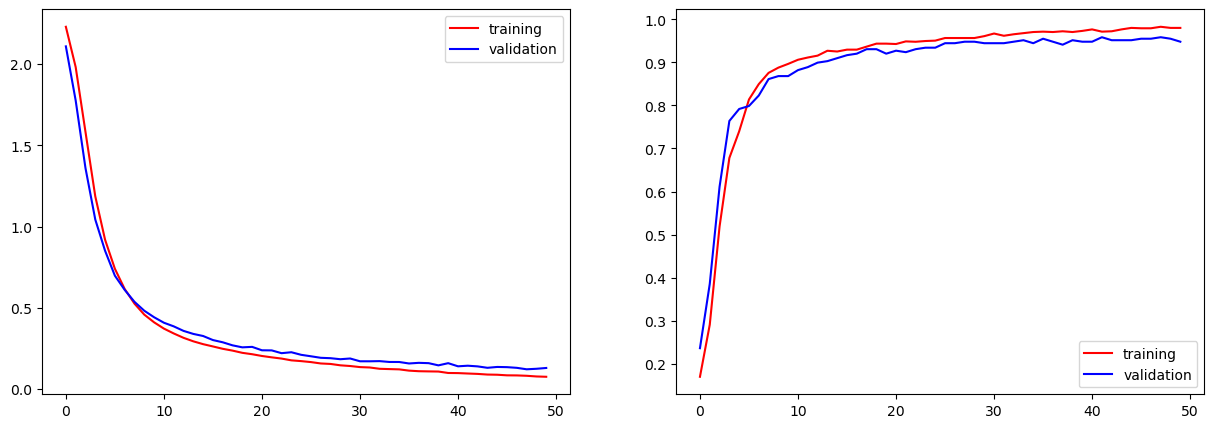

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [62]:
model.predict(X_test)[0]

12/12 [==============================] - 0s 3ms/step


array([8.2608769e-03, 1.9346448e-04, 1.2849141e-05, 1.1053107e-10,
       2.8869254e-04, 9.9810095e-06, 9.8747462e-01, 8.3880153e-08,
       3.7592566e-03, 1.0019008e-07], dtype=float32)

In [63]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 3ms/step


In [64]:
y_hat_test

array([6, 9, 3, 7, 2, 6, 5, 2, 5, 2, 1, 8, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 3, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 4, 4, 4, 1, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 8, 7, 2, 9, 0, 6, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 2, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 1, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 0, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 3, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [65]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[32,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 32,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  2,  0,  0, 43,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 45,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  2,  0,  0,  0,  1,  0,  0, 27,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  2, 35]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
